# Plotting panels of spectra of LRDs

In [3]:
## importing libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import pandas as pd

### Information

- Each panel has 8 spectra (4 x 2)
- I'll use F_lambda for the plots

### Open de Graaf's file to access the name of the spectra files and the redshifts

In [ ]:
hdul = fits.open("deGraaff2025_lrds_withdups_blackbody_eline_fits.fits")
hdul.info()
data = hdul[1].data

files = data["file"]
redshifts = data["zspec"]

#transforming into numpy arrays
files = np.array(files)
redshifts = np.array(redshifts)

spec_info_all = list(zip(files, redshifts))

#removing info from the spectra of program MoM (GO5224) since we don't have its spectra
spec_info = spec_info_all[:59] + spec_info_all[72:]
print(len(spec_info))


Filename: deGraaff2025_lrds_withdups_blackbody_eline_fits.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  PHOT          1 BinTableHDU     94   134R x 32C   [K, K, 24A, 57A, D, D, D, D, D, K, 196A, L, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D]   
(np.str_('nexus-obs3-v4_prism-clear_5105_10835.spec.fits'), np.float64(4.65012))
121


### Plot the panels

In [46]:
def read_and_convert_spectrum(fits_path):
    """
    Lê um FITS de espectro e retorna:
    wave_um, Flam_e20
    """
    c = 2.998e10  # cm/s

    with fits.open(fits_path) as hdul:
        data = hdul[1].data
        wave_um = data['wave']
        flux_uJy = data['flux']

    # µJy -> erg/s/cm^2/Hz
    Fnu = flux_uJy * 1e-29

    lam_cm = wave_um * 1e-4

    # F_lambda in erg/s/cm^2/Å
    Flam = Fnu * c / lam_cm**2 / 1e8

    Flam_e20 = Flam * 1e20

    return wave_um, Flam_e20

def plot_spectrum_ax(ax, wave_um, Flam_e20, title=None, z=None):
    ax.plot(wave_um, Flam_e20)

    ax.set_xlim(0.4, 5.6)
    ax.set_ylim(-0.5, 3.5)
    ax.set_xticks(np.arange(0.5, 5.5, 0.5))
    ax.grid(True)

    if title is not None:
        ax.set_title(title, fontsize=10)

    if z is not None:
        ax.text(
            0.97, 0.95,
            f"z = {z:.3f}",
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )

import matplotlib.pyplot as plt

def make_spectrum_panel(
    spec_info,
    start=0,
    nrows=4,
    ncols=2,
    base_path="DeGraaff_espectros"
):
    """
    spec_info: lista de tuplas (filename, z)
    start: índice inicial do painel
    """

    n_panel = nrows * ncols
    subset = spec_info[start:start + n_panel]

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(14, 4 * nrows),
        sharex=True, sharey=True
    )
    axes = axes.flatten()

    for ax, (fname, z) in zip(axes, subset):

        fits_path = f"{base_path}/{fname}"
        wave_um, Flam_e20 = read_and_convert_spectrum(fits_path)

        plot_spectrum_ax(
            ax,
            wave_um,
            Flam_e20,
            title=fname,
            z=z
        )

    # Remove eixos vazios (último painel pode não estar completo)
    for ax in axes[len(subset):]:
        ax.axis("off")

    fig.supxlabel(r'Observed Wavelength [$\mu$m]', fontsize=14)
    fig.supylabel(
        r'Flux [10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]',
        fontsize=14
    )

    plt.tight_layout()
    return fig


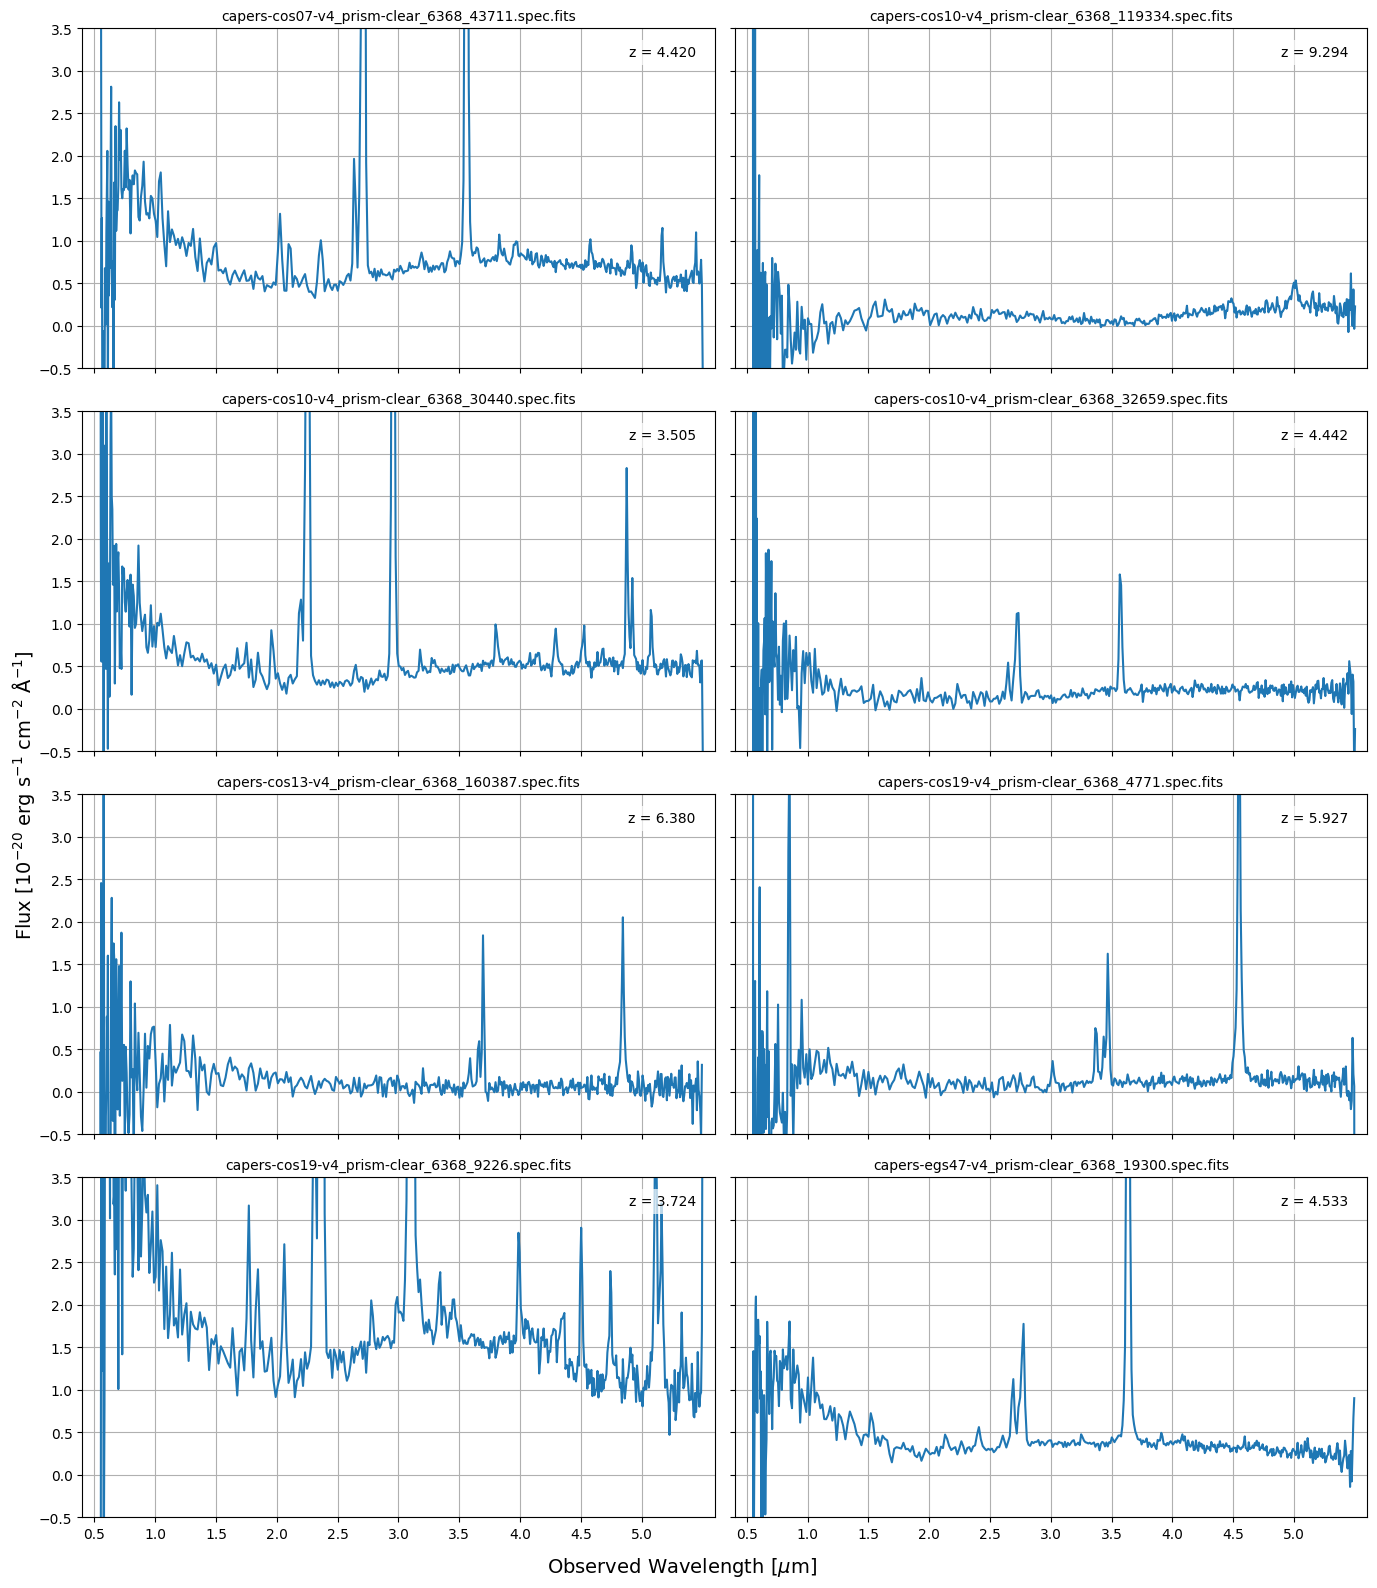

In [47]:
make_spectrum_panel(spec_info, start=0)
plt.show()

In [48]:
for start in range(0, len(spec_info), 8):
    fig = make_spectrum_panel(spec_info, start=start)
    fig.savefig(f"spectra_panel_{start//8:02d}.pdf")
    plt.close(fig)


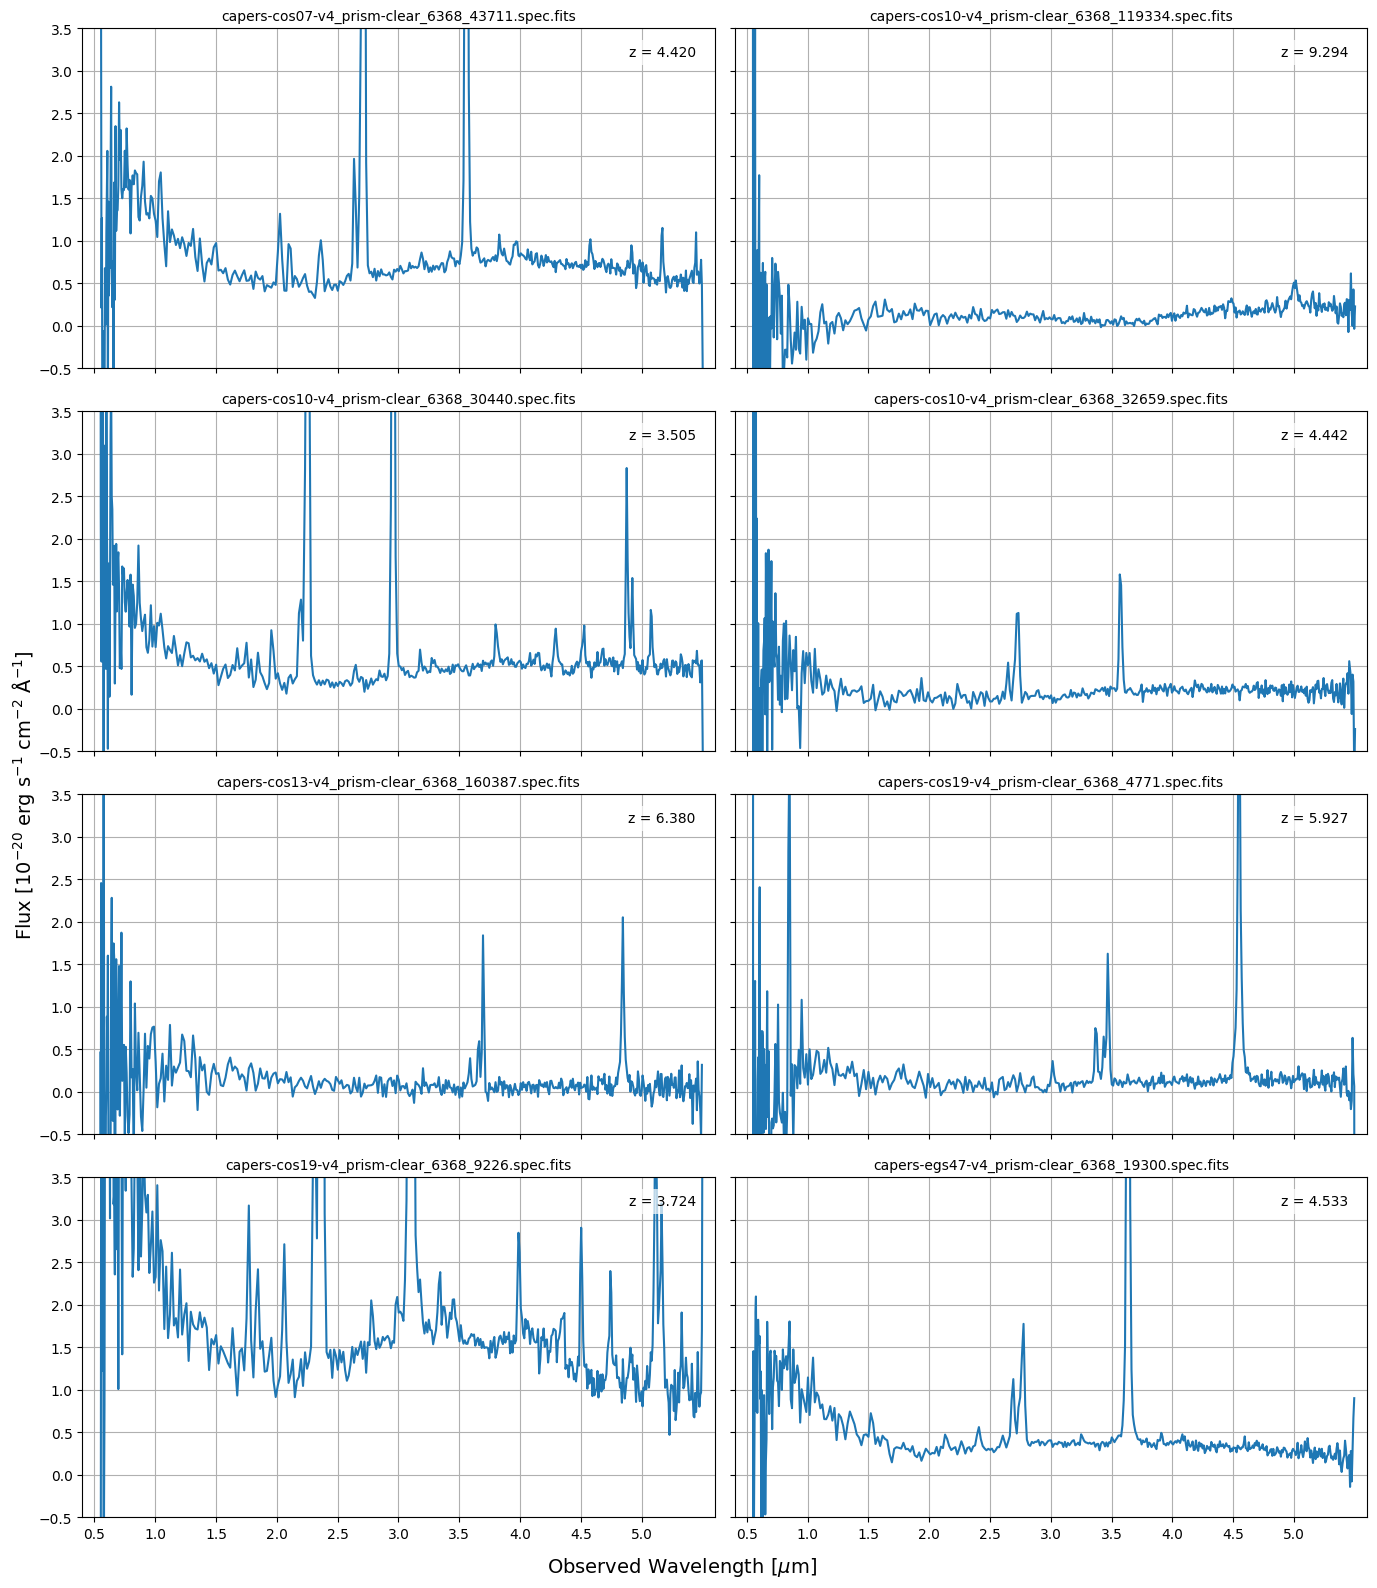

In [ ]:
## Paineis individuais:

# Constante
c = 2.998e10  # cm/s

# Cria o painel: 4 linhas, 2 colunas
fig, axes = plt.subplots(4, 2, figsize=(14, 16), sharex=True, sharey=True)
axes = axes.flatten()  # transforma em lista 1D para facilitar o loop

for i, (fname,z) in enumerate(spec_info[0:8]):

    # 1. Open the FITS file
    fits_file_path = f"DeGraaff_espectros/{fname}"
    hdul = fits.open(fits_file_path)

    # 2. Access the data
    data = hdul[1].data

    wave_um = data['wave']
    flux_uJy = data['flux']
    err_uJy  = data['err']

    # µJy -> erg/s/cm^2/Hz
    Fnu = flux_uJy * 1e-29
    Ferr_nu = err_uJy * 1e-29

    # wavelength in cm
    lam_cm = wave_um * 1e-4

    # F_lambda in erg/s/cm^2/Å
    Flam = Fnu * c / lam_cm**2 / 1e8
    Ferr_lam = Ferr_nu * c / lam_cm**2 / 1e8

    Flam_e20 = Flam * 1e20

    hdul.close()

    # 3. Plot
    ax = axes[i]
    ax.plot(wave_um, Flam_e20)
    ax.set_title(fname, fontsize=10)

    ax.set_xlim(0.4, 5.6)
    ax.set_ylim(-0.5, 3.5)
    ax.set_xticks(np.arange(0.5, 5.5, 0.5))
    ax.grid(True)

    ax.text(
        0.97, 0.95,                # posição (em coordenadas do eixo)
        f"z = {z:.3f}",             # formato do texto
        transform=ax.transAxes,    # coordenadas relativas ao painel
        ha='right', va='top',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

# Rótulos globais
fig.supxlabel(r'Observed Wavelength [$\mu$m]', fontsize=14)
fig.supylabel(r'Flux [10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]', fontsize=14)

plt.tight_layout()
plt.savefig("painel_1.pdf")
plt.show()
